# Idea behind the project
Creating a prediction tool to predict the likelihood of 4 different possible outcomes of a fight between two fighters in a mixed martial arts setting. Data from Kaggle will be used and cleaned in order to provide the necessary data to teach a model to predict the outcomes.

# Imports

In [25]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import numpy as np

import altair as alt

#Modelling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, \
    mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVR
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

# Oversampling, undersampling, hyperparameter tuning
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

#Scrapping
import requests
from bs4 import BeautifulSoup

#Saving the models
import joblib

# Data preparation

In [26]:
# file = 'UFCMaster/ufc-master.csv'
file = 'ufc_dataset.xlsx'
ufc_data_master = pd.read_excel(file)

ufc_data_master.head()

,RedFighter,BlueFighter,RedOdds,BlueOdds,RedExpectedValue,BlueExpectedValue,Date,Location,Country,Winner,...,Blue_Str_Def,Blue_TD_Avg,Blue_TD_Acc,Blue_TD_Def,Blue_Sub_Avg,SLpM Diff,Exp. Str. Acc. Diff.,TD Avg. Diff.,Exp. TD Acc. Diff.,Sub Avg. Diff.
0,Ciryl Gane,Alexander Volkov,-380.0,300.0,26.3158,300.0,2024-12-07,"Las Vegas, Nevada, USA",USA,Red,...,0.12,-0.65,1.55,0.22,-0.56,0.21,-1.258571,0.28,-0.361982,0.36
1,Bryce Mitchell,Kron Gracie,-950.0,625.0,10.5263,625.0,2024-12-07,"Las Vegas, Nevada, USA",USA,Red,...,-0.25,-0.48,-0.58,-2.69,0.42,-2.06,1.016858,1.76,0.933381,1.91
2,Nate Landwehr,Dooho Choi,-130.0,110.0,76.9231,110.0,2024-12-07,"Las Vegas, Nevada, USA",USA,Blue,...,-0.25,-0.84,-0.82,-0.49,-0.84,1.39,0.089169,-0.41,0.401995,-0.06
3,Dominick Reyes,Anthony Smith,-380.0,300.0,26.3158,300.0,2024-12-07,"Las Vegas, Nevada, USA",USA,Red,...,-1.63,-0.78,-0.44,-0.44,0.14,1.16,0.232254,-0.31,0.000000,-0.76
4,Movsar Evloev,Aljamain Sterling,-238.0,195.0,42.0168,195.0,2024-12-07,"Las Vegas, Nevada, USA",USA,Red,...,1.00,0.20,-0.63,-0.88,0.42,-0.02,0.079373,0.69,0.000000,-1.32


## Conversion of weight (lbs) to weight (kg)
This conversion is a personal preference, I feel more confident working with kilos instead of pounds

In [27]:
ufc_data_master["BlueWeightKg"] = ufc_data_master["BlueWeightLbs"] * 0.453592
ufc_data_master["RedWeightKg"] = ufc_data_master["RedWeightLbs"] * 0.453592

ufc_data_master = ufc_data_master.drop(columns=["BlueWeightLbs", "RedWeightLbs"])

## Dropping unnecessary features
All the unnecessary features are being dropped. The file inittialy had 118 features, however after carefully analysing all the different features, the number of features were reduced to 49. Most of the dropped features are rankings that are not directly related with fight prediction. As well as other features that do not really contribute to the prediction of a bout.

In [28]:
features_to_drop = [
    
    # Blue features
    "BlueFighter","BlueExpectedValue", "BMatchWCRank", "BWFlyweightRank", "BWFeatherweightRank",
    "BWStrawweightRank", "BWBantamweightRank", "BHeavyweightRank",
    "BLightHeavyweightRank", "BMiddleweightRank", "BWelterweightRank",
    "BLightweightRank", "BFeatherweightRank", "BBantamweightRank",
    "BFlyweightRank", "BPFPRank","BlueCurrentLoseStreak","BlueCurrentWinStreak",
    "BlueDraws", "BlueLongestWinStreak","BlueLosses","BlueTotalRoundsFought","BlueTotalTitleBouts",
    "BlueWinsByDecisionMajority","BlueWinsByDecisionSplit","BlueWinsByDecisionUnanimous",
    "BlueWinsByKO","BlueWinsBySubmission","BlueWinsByTKODoctorStoppage",
    "BlueWins",
    "BlueAvgSigStrPct",
    "BlueAvgTDPct", "Blue_Weight", "Blue_Reach", "Blue_DOB","Blue_Stance","Blue_Height",

    
    # Red features
    "RedFighter","RedExpectedValue", "RMatchWCRank", "RWFlyweightRank", "RWFeatherweightRank",
    "RWStrawweightRank", "RWBantamweightRank", "RHeavyweightRank",
    "RLightHeavyweightRank", "RMiddleweightRank", "RWelterweightRank",
    "RLightweightRank", "RFeatherweightRank", "RBantamweightRank",
    "RFlyweightRank", "RPFPRank","RedCurrentLoseStreak","RedCurrentWinStreak","RedDraws","RedLongestWinStreak","RedLosses",
    "RedTotalRoundsFought","RedTotalTitleBouts","RedWinsByDecisionMajority",
    "RedWinsByDecisionSplit","RedWinsByDecisionUnanimous","RedWinsByKO",
    "RedWinsBySubmission","RedWinsByTKODoctorStoppage", "RedWins","RedAvgSigStrPct",
    'RedAvgTDPct',"Red_Weight","Red_Reach","Red_DOB","Red_Stance","Red_Height",
    
    # Other
    "Date", "Location", "Country", "TitleBout","WeightClass", "EmptyArena","BetterRank","FinishRoundTime","TotalFightTimeSecs","FinishRound","TotalTitleBoutDif","NumberOfRounds", "TotalRoundDif",
    "LoseStreakDif","WinDif","LossDif","LongestWinStreakDif", "WinStreakDif","KODif","SubDif"
]

ufc_data_master = ufc_data_master.drop(columns = features_to_drop)

ufc_data_master.columns

Index(['RedOdds', 'BlueOdds', 'Winner', 'Gender', 'BlueAvgSigStrLanded',
       'BlueAvgSubAtt', 'BlueAvgTDLanded', 'BlueStance', 'BlueHeightCms',
       'BlueReachCms', 'RedAvgSigStrLanded', 'RedAvgSubAtt', 'RedAvgTDLanded',
       'RedStance', 'RedHeightCms', 'RedReachCms', 'RedAge', 'BlueAge',
       'HeightDif', 'ReachDif', 'AgeDif', 'SigStrDif', 'AvgSubAttDif',
       'AvgTDDif', 'Finish', 'FinishDetails', 'RedDecOdds', 'BlueDecOdds',
       'RSubOdds', 'BSubOdds', 'RKOOdds', 'BKOOdds', 'Red_SLpM', 'Red_Str_Acc',
       'Red_SApM', 'Red_Str_Def', 'Red_TD_Avg', 'Red_TD_Acc', 'Red_TD_Def',
       'Red_Sub_Avg', 'Blue_SLpM', 'Blue_Str_Acc', 'Blue_SApM', 'Blue_Str_Def',
       'Blue_TD_Avg', 'Blue_TD_Acc', 'Blue_TD_Def', 'Blue_Sub_Avg',
       'SLpM Diff', 'Exp. Str. Acc. Diff.', 'TD Avg. Diff.',
       'Exp. TD Acc. Diff.', 'Sub Avg. Diff.', 'BlueWeightKg', 'RedWeightKg'],
      dtype='object')

## One-hot-encoding the 'Finish' feature
One-hot-encoding is used to transform categorical values into numerical values. In my case the 'Finish' feature had 5 different types of finishes. When I one-hot-encode the 'Finish' feature I get 5 different columns with all the possible finishes and a match has a true or false to the according finish. It is not a good idea to use factorizing with that many different options because the model could develop bias towards a bigger number.

**Issue** -> The issue it solves is the models I am using need to have a numerical value instead of categorical.


**Solution** -> One-hot-encoding is used instead of factorizing to reduce the model bias.

In [29]:
ufc_data_master = pd.get_dummies(ufc_data_master, columns = ['Finish'], prefix='Finish')

ufc_data_master.head()

,RedOdds,BlueOdds,Winner,Gender,BlueAvgSigStrLanded,BlueAvgSubAtt,BlueAvgTDLanded,BlueStance,BlueHeightCms,BlueReachCms,...,Sub Avg. Diff.,BlueWeightKg,RedWeightKg,Finish_DQ,Finish_KO/TKO,Finish_M-DEC,Finish_Overturned,Finish_S-DEC,Finish_SUB,Finish_U-DEC
0,-380.0,300.0,Red,MALE,5.13,0.2,0.45,Orthodox,200.66,203.20,...,0.36,113.39800,111.13004,False,False,False,False,True,False,False
1,-950.0,625.0,Red,MALE,3.74,0.5,0.47,Southpaw,175.26,177.80,...,1.91,65.77084,65.77084,False,True,False,False,False,False,False
2,-130.0,110.0,Blue,MALE,4.41,0.8,0.75,Orthodox,177.80,177.80,...,-0.06,65.77084,65.77084,False,True,False,False,False,False,False
3,-380.0,300.0,Red,MALE,3.24,0.6,0.46,Orthodox,193.04,193.04,...,-0.76,92.98636,92.98636,False,True,False,False,False,False,False
4,-238.0,195.0,Red,MALE,4.61,0.7,2.31,Orthodox,170.18,180.34,...,-1.32,65.77084,65.77084,False,False,False,False,False,False,True


## One-hot-encoding the 'Stance' feature 
I have three different stances that a fighter could have. I am one-hot-encoding it to make the categorical data to numerical, since the models I am using require numerical data.

In [30]:
ufc_data_master = pd.get_dummies(ufc_data_master, columns = ['RedStance'], prefix = 'RedStance')
ufc_data_master = pd.get_dummies(ufc_data_master, columns = ['BlueStance'], prefix = 'BlueStance')

ufc_data_master.head()

,RedOdds,BlueOdds,Winner,Gender,BlueAvgSigStrLanded,BlueAvgSubAtt,BlueAvgTDLanded,BlueHeightCms,BlueReachCms,RedAvgSigStrLanded,...,Finish_U-DEC,RedStance_Open Stance,RedStance_Orthodox,RedStance_Southpaw,RedStance_Switch,BlueStance_Open Stance,BlueStance_Orthodox,BlueStance_Southpaw,BlueStance_Switch,BlueStance_Switch
0,-380.0,300.0,Red,MALE,5.13,0.2,0.45,200.66,203.20,5.49,...,False,False,True,False,False,False,True,False,False,False
1,-950.0,625.0,Red,MALE,3.74,0.5,0.47,175.26,177.80,2.30,...,False,False,False,True,False,False,False,True,False,False
2,-130.0,110.0,Blue,MALE,4.41,0.8,0.75,177.80,177.80,6.25,...,False,False,True,False,False,False,True,False,False,False
3,-380.0,300.0,Red,MALE,3.24,0.6,0.46,193.04,193.04,4.87,...,False,False,False,True,False,False,True,False,False,False
4,-238.0,195.0,Red,MALE,4.61,0.7,2.31,170.18,180.34,4.43,...,True,False,True,False,False,False,True,False,False,False


## Factorizing 'Winner'
The 'Winner' feature had either 'Red' or 'Blue' as a winner, in order to normalize it I factorized the feature providing me with a binary value 0 or 1, where **0 is Red** and **1 is Blue**

This was needed because my models could not use the string type of the feature to model the data

In [31]:
ufc_data_master['Winner'], winner_mapping = pd.factorize(ufc_data_master['Winner'])

ufc_data_master.head()

,RedOdds,BlueOdds,Winner,Gender,BlueAvgSigStrLanded,BlueAvgSubAtt,BlueAvgTDLanded,BlueHeightCms,BlueReachCms,RedAvgSigStrLanded,...,Finish_U-DEC,RedStance_Open Stance,RedStance_Orthodox,RedStance_Southpaw,RedStance_Switch,BlueStance_Open Stance,BlueStance_Orthodox,BlueStance_Southpaw,BlueStance_Switch,BlueStance_Switch
0,-380.0,300.0,0,MALE,5.13,0.2,0.45,200.66,203.20,5.49,...,False,False,True,False,False,False,True,False,False,False
1,-950.0,625.0,0,MALE,3.74,0.5,0.47,175.26,177.80,2.30,...,False,False,False,True,False,False,False,True,False,False
2,-130.0,110.0,1,MALE,4.41,0.8,0.75,177.80,177.80,6.25,...,False,False,True,False,False,False,True,False,False,False
3,-380.0,300.0,0,MALE,3.24,0.6,0.46,193.04,193.04,4.87,...,False,False,False,True,False,False,True,False,False,False
4,-238.0,195.0,0,MALE,4.61,0.7,2.31,170.18,180.34,4.43,...,True,False,True,False,False,False,True,False,False,False


## Factorizing 'Gender'
The 'Gender' feature was factorized for the same reason as the 'Winner' feature. I had only two possible values 'Man' or 'Woman', now the **0 is man ** and 1 is woman**.

Using one-hot-encoding is not best practise here because the feature is binary, always either 0 or 1. When there are more than 2 values then one-hot-encoding should be considered. As well as, one-hot-encoding would have created more columns which just adds up to the training time in this case.

In [32]:
ufc_data_master['Gender'], gender_mapping = pd.factorize(ufc_data_master['Gender'])

ufc_data_master.head()

,RedOdds,BlueOdds,Winner,Gender,BlueAvgSigStrLanded,BlueAvgSubAtt,BlueAvgTDLanded,BlueHeightCms,BlueReachCms,RedAvgSigStrLanded,...,Finish_U-DEC,RedStance_Open Stance,RedStance_Orthodox,RedStance_Southpaw,RedStance_Switch,BlueStance_Open Stance,BlueStance_Orthodox,BlueStance_Southpaw,BlueStance_Switch,BlueStance_Switch
0,-380.0,300.0,0,0,5.13,0.2,0.45,200.66,203.20,5.49,...,False,False,True,False,False,False,True,False,False,False
1,-950.0,625.0,0,0,3.74,0.5,0.47,175.26,177.80,2.30,...,False,False,False,True,False,False,False,True,False,False
2,-130.0,110.0,1,0,4.41,0.8,0.75,177.80,177.80,6.25,...,False,False,True,False,False,False,True,False,False,False
3,-380.0,300.0,0,0,3.24,0.6,0.46,193.04,193.04,4.87,...,False,False,False,True,False,False,True,False,False,False
4,-238.0,195.0,0,0,4.61,0.7,2.31,170.18,180.34,4.43,...,True,False,True,False,False,False,True,False,False,False


## Filling in the NULL values of all the columns


In [33]:
ufc_data_master["RedOdds"] = ufc_data_master["RedOdds"].fillna(0)
ufc_data_master["BlueOdds"] = ufc_data_master["BlueOdds"].fillna(0)
ufc_data_master['BlueAvgSigStrLanded'] = ufc_data_master['BlueAvgSigStrLanded'].fillna(0.0)
ufc_data_master['BlueAvgSubAtt'] = ufc_data_master['BlueAvgSubAtt'].fillna(0.0)
ufc_data_master['BlueAvgTDLanded'] = ufc_data_master['BlueAvgTDLanded'].fillna(0.0)
ufc_data_master['RedAvgSigStrLanded'] = ufc_data_master['RedAvgSigStrLanded'].fillna(0)
ufc_data_master['RedAvgSubAtt'] = ufc_data_master['RedAvgSubAtt'].fillna(0)
ufc_data_master['RedAvgTDLanded'] = ufc_data_master['RedAvgTDLanded'].fillna(0)
ufc_data_master['RedDecOdds'] = ufc_data_master['RedDecOdds'].fillna(0)
ufc_data_master['BlueDecOdds'] = ufc_data_master['BlueDecOdds'].fillna(0)
ufc_data_master['RSubOdds'] = ufc_data_master['RSubOdds'].fillna(0)
ufc_data_master['BSubOdds'] = ufc_data_master['BSubOdds'].fillna(0)
ufc_data_master['RKOOdds'] = ufc_data_master['RKOOdds'].fillna(0)
ufc_data_master['BKOOdds'] = ufc_data_master['BKOOdds'].fillna(0)

# ufc_data_master.head()

ufc_data_master.to_excel("ufc_dataset_final.xlsx", index=False)

# Visualizing correlations

## Correlation between match statistics to the 'Winner' feature

A correlation matrix displaying each feature in the dataset compared to the target variable 'Winner', displaying its correlation with it. Pearson correlation


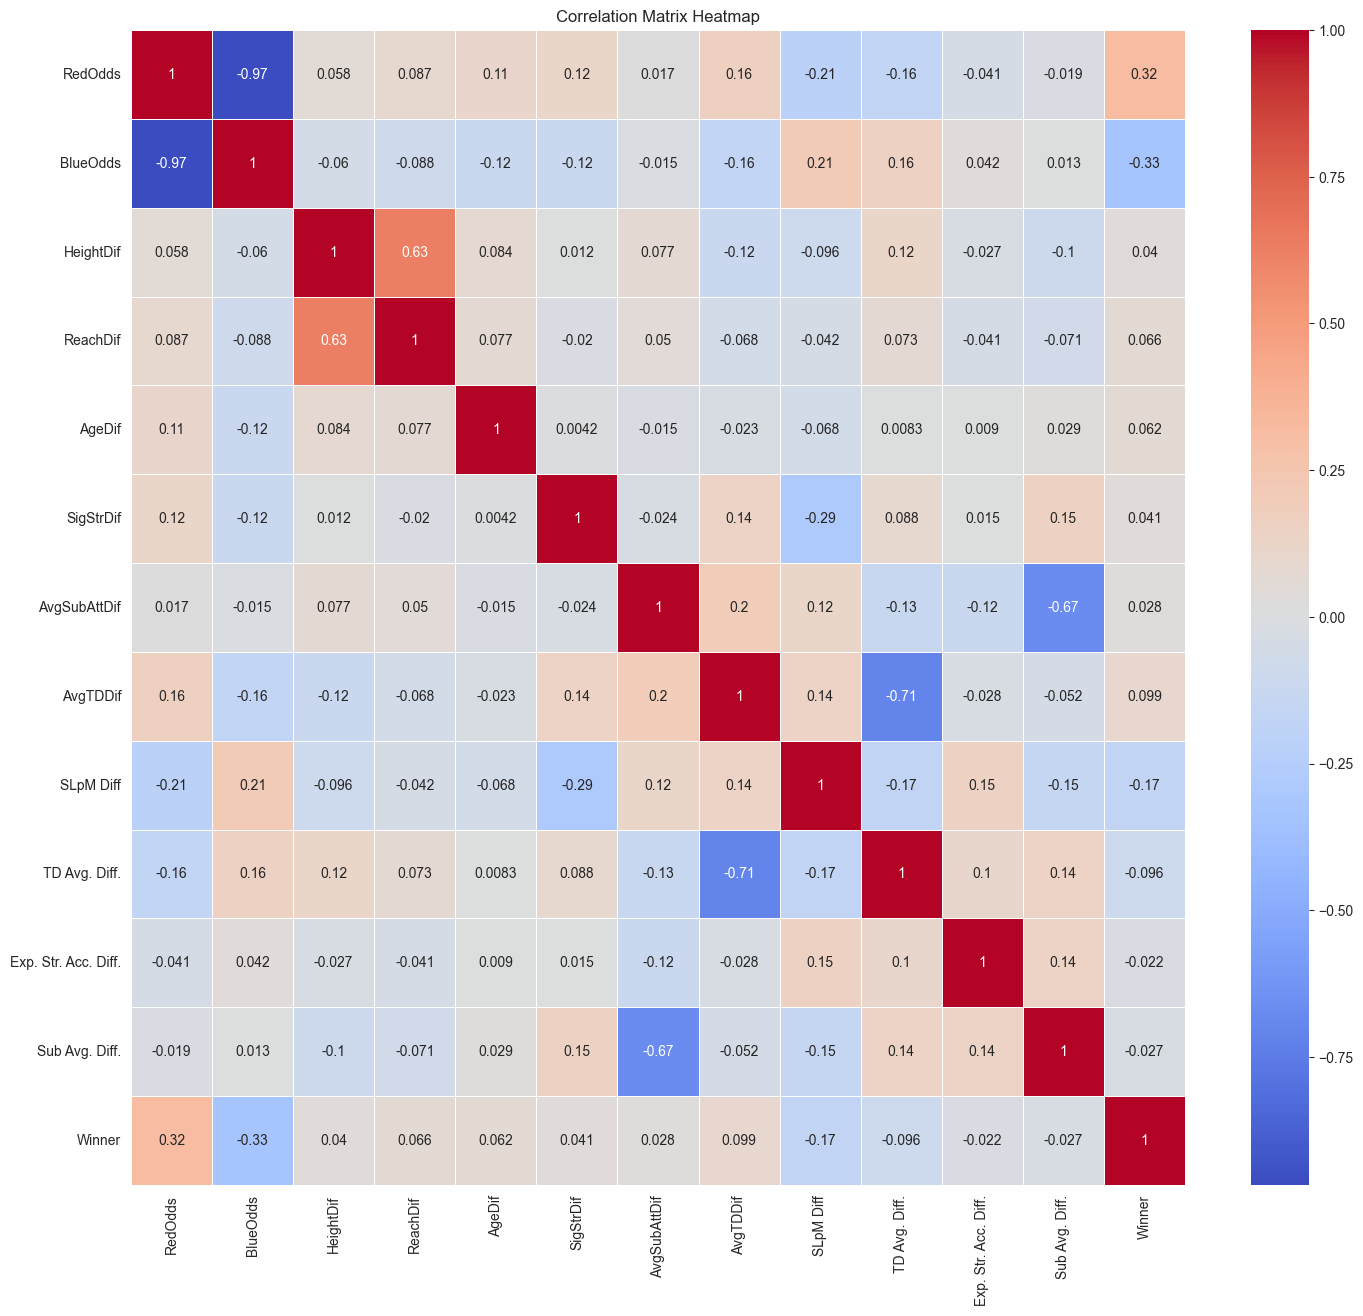

In [34]:
selected_features = [
    "RedOdds", "BlueOdds", "HeightDif", "ReachDif", "AgeDif", "SigStrDif", 
    "AvgSubAttDif", "AvgTDDif","SLpM Diff",
       "TD Avg. Diff.", "Exp. Str. Acc. Diff.", "Sub Avg. Diff.", "Winner"
]

data_for_correlation = ufc_data_master[selected_features]

correlation_matrix = data_for_correlation.corr()

plt.figure(figsize=(17, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

## Red winner statistics matrix

Pearson correlation only for the 'Red' fighter. Where 'Winner' is 'Red'

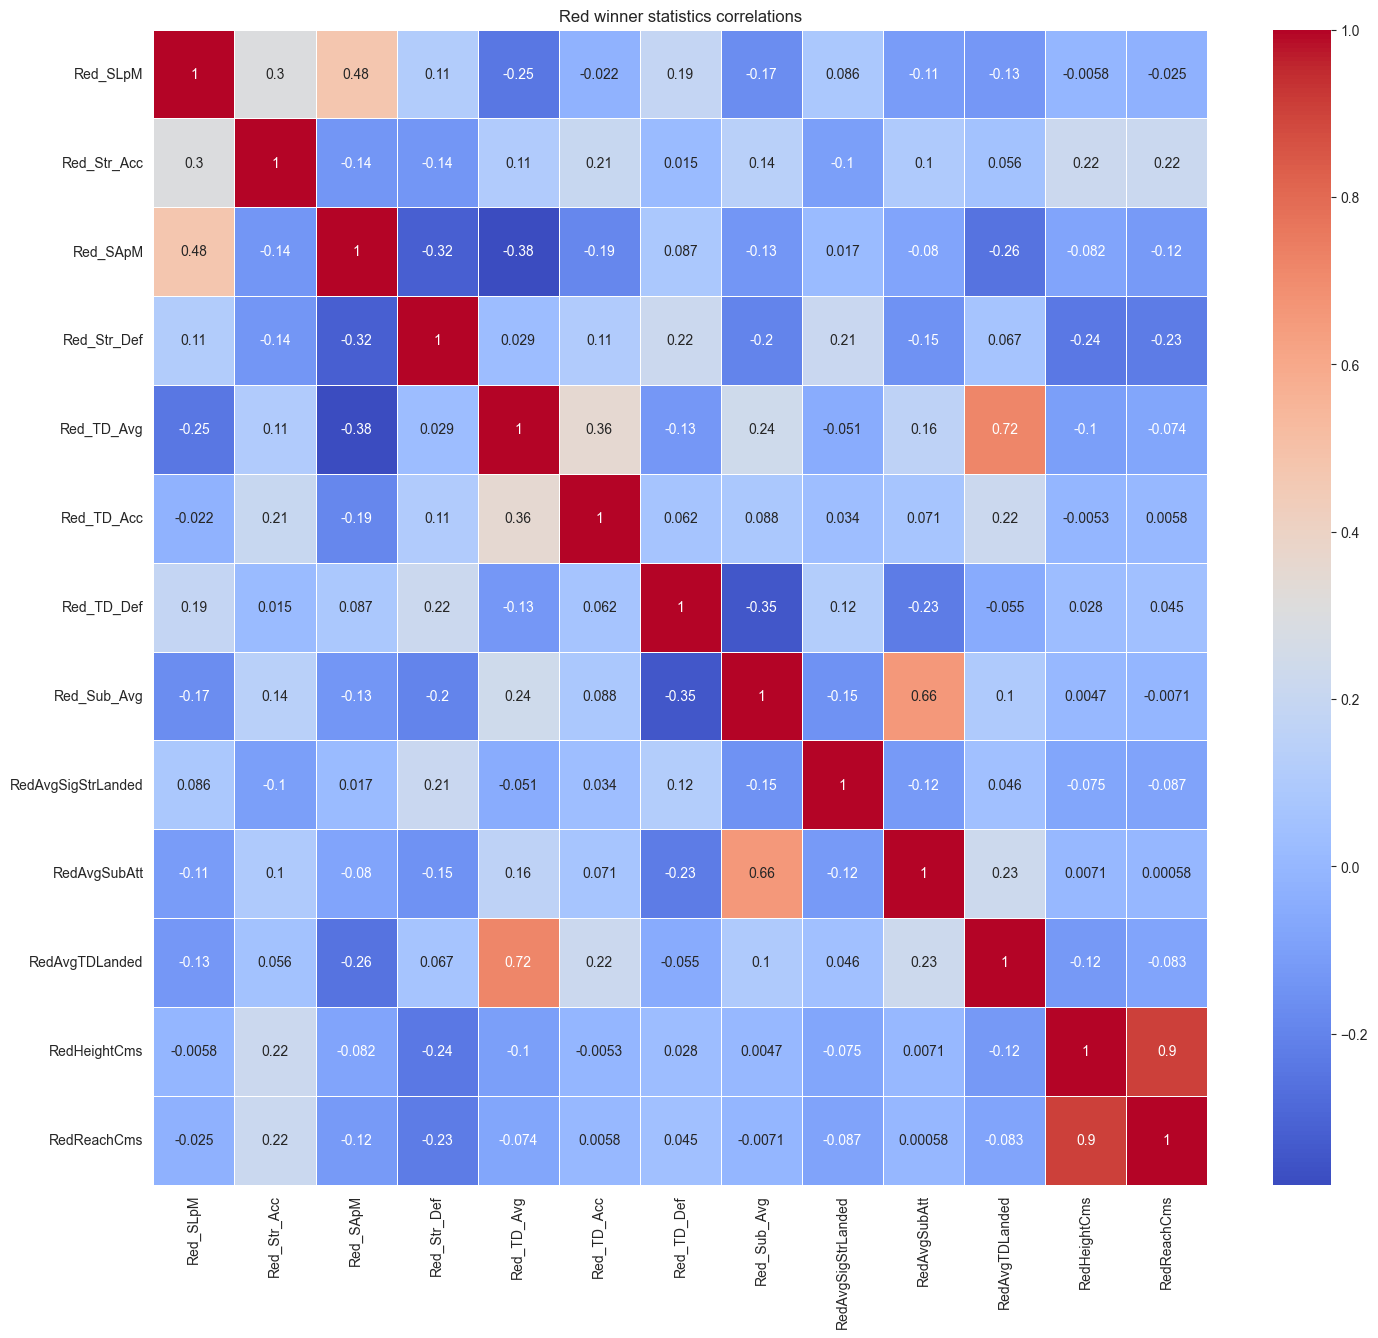

In [35]:
red_features = ["Red_SLpM",	"Red_Str_Acc","Red_SApM","Red_Str_Def", "Red_TD_Avg","Red_TD_Acc","Red_TD_Def", "Red_Sub_Avg","RedAvgSigStrLanded","RedAvgSubAtt","RedAvgTDLanded","RedHeightCms","RedReachCms"]

red_winner = ufc_data_master[ufc_data_master['Winner'] == 0]

data_for_correlation_red_winner = red_winner[red_features]

correlation_matrix_winner_0 = data_for_correlation_red_winner.corr()

# Plot the heatmap
plt.figure(figsize=(17, 15))
sns.heatmap(correlation_matrix_winner_0, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Red winner statistics correlations')
plt.show()

## Blue winner statistics matrix

Pearson correlation only for the 'Blue' fighter. Where 'Winner' is 'Blue'



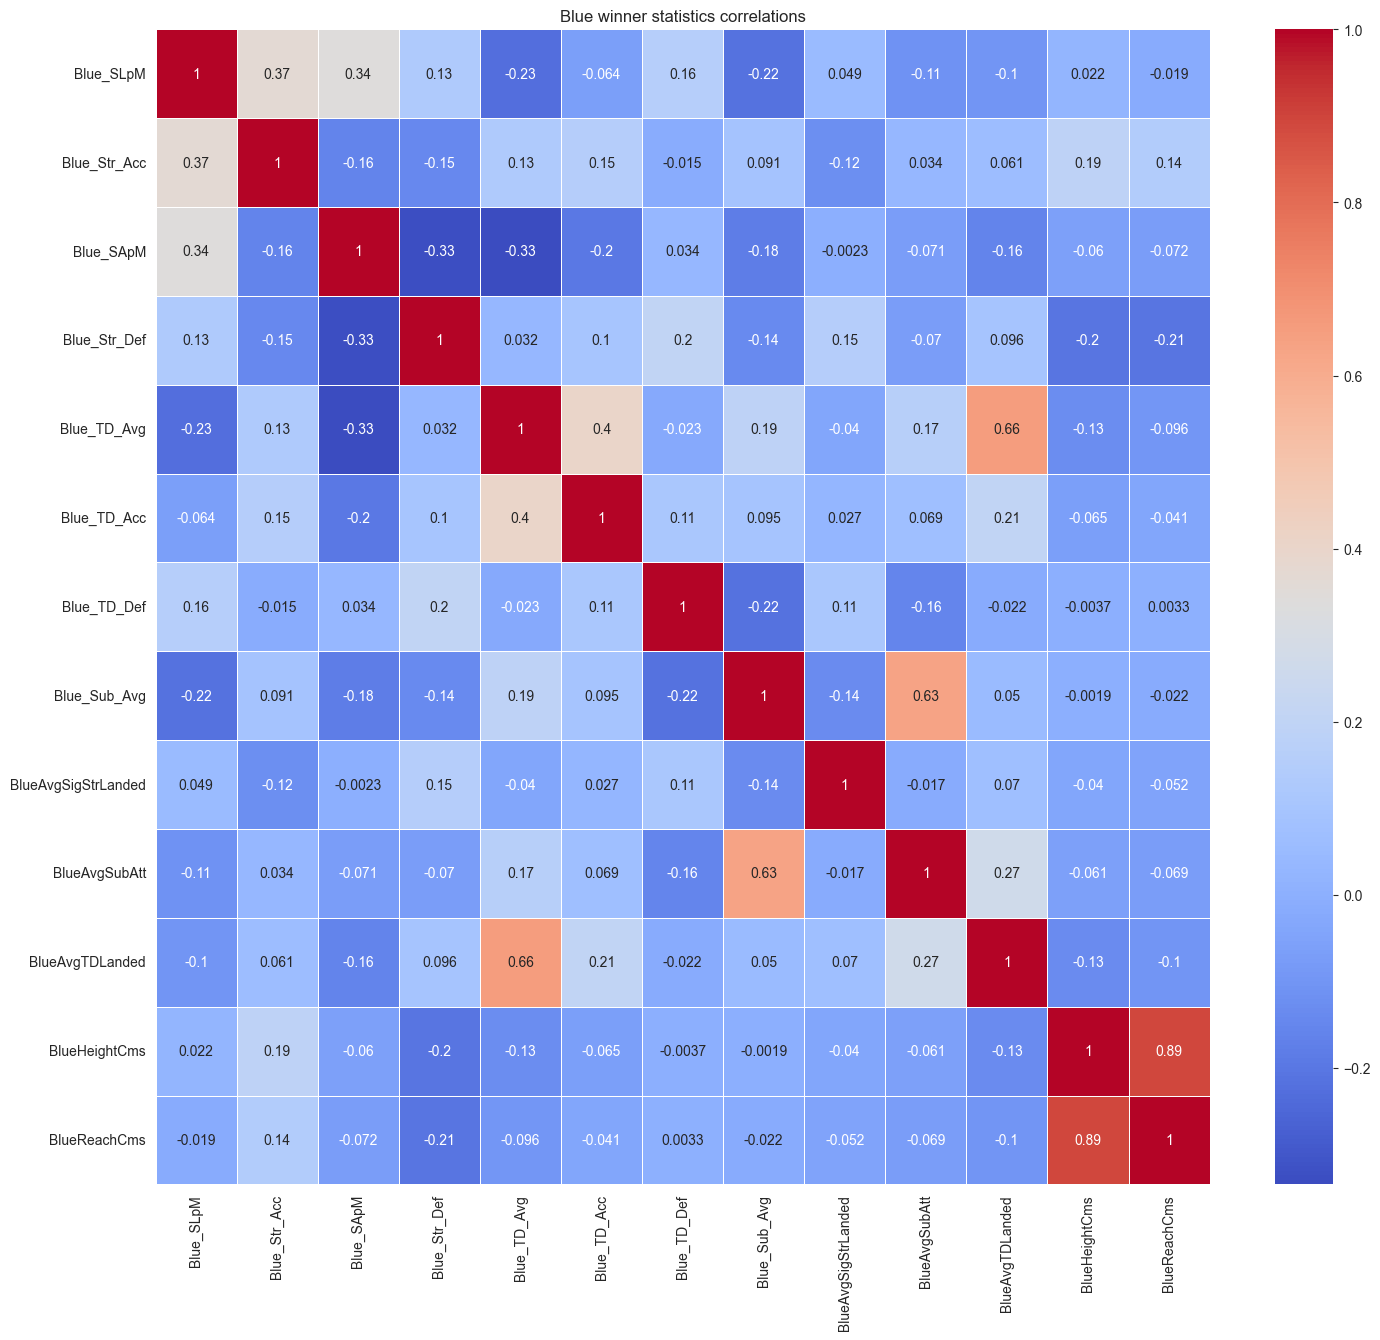

In [36]:
blue_features = ["Blue_SLpM","Blue_Str_Acc","Blue_SApM","Blue_Str_Def", "Blue_TD_Avg","Blue_TD_Acc","Blue_TD_Def", "Blue_Sub_Avg","BlueAvgSigStrLanded","BlueAvgSubAtt","BlueAvgTDLanded","BlueHeightCms","BlueReachCms"]

blue_winner = ufc_data_master[ufc_data_master['Winner'] == 1]

data_for_correlation_blue_winner = blue_winner[blue_features]

correlation_matrix_winner_0 = data_for_correlation_blue_winner.corr()

# Plot the heatmap
plt.figure(figsize=(17, 15))
sns.heatmap(correlation_matrix_winner_0, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Blue winner statistics correlations')
plt.show()

## KO/TKO statistics matrix (Strikes statistics)

Correlation matrix to display how strong of a correlation the features have to predict the 'Finish_KO/TKO' fight outcome.


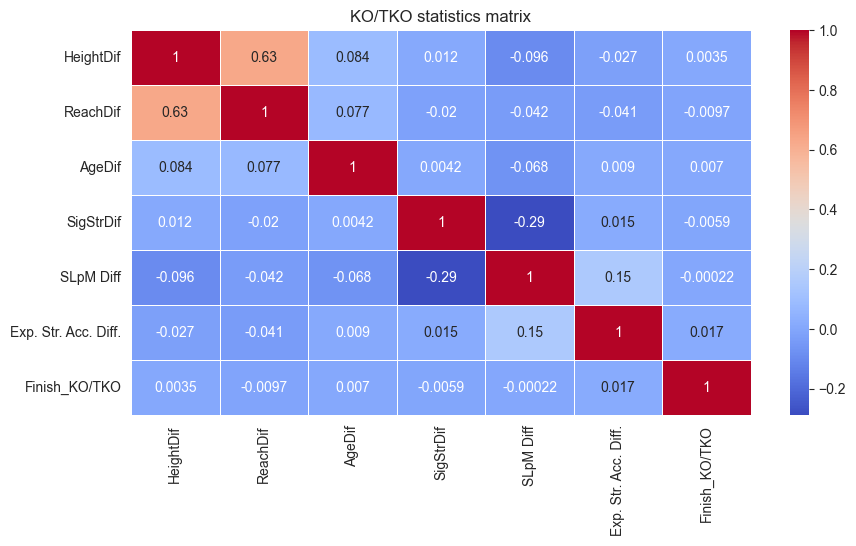

In [37]:
ko_tko_features = ["HeightDif","ReachDif","AgeDif","SigStrDif","SLpM Diff","Exp. Str. Acc. Diff.","Finish_KO/TKO"]

data_for_correlation_ko_tko = ufc_data_master[ko_tko_features]

correlation_matrix_ko_tko = data_for_correlation_ko_tko.corr()

plt.figure(figsize=(10,5))
sns.heatmap(correlation_matrix_ko_tko, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('KO/TKO statistics matrix')
plt.show()

## Most common finish

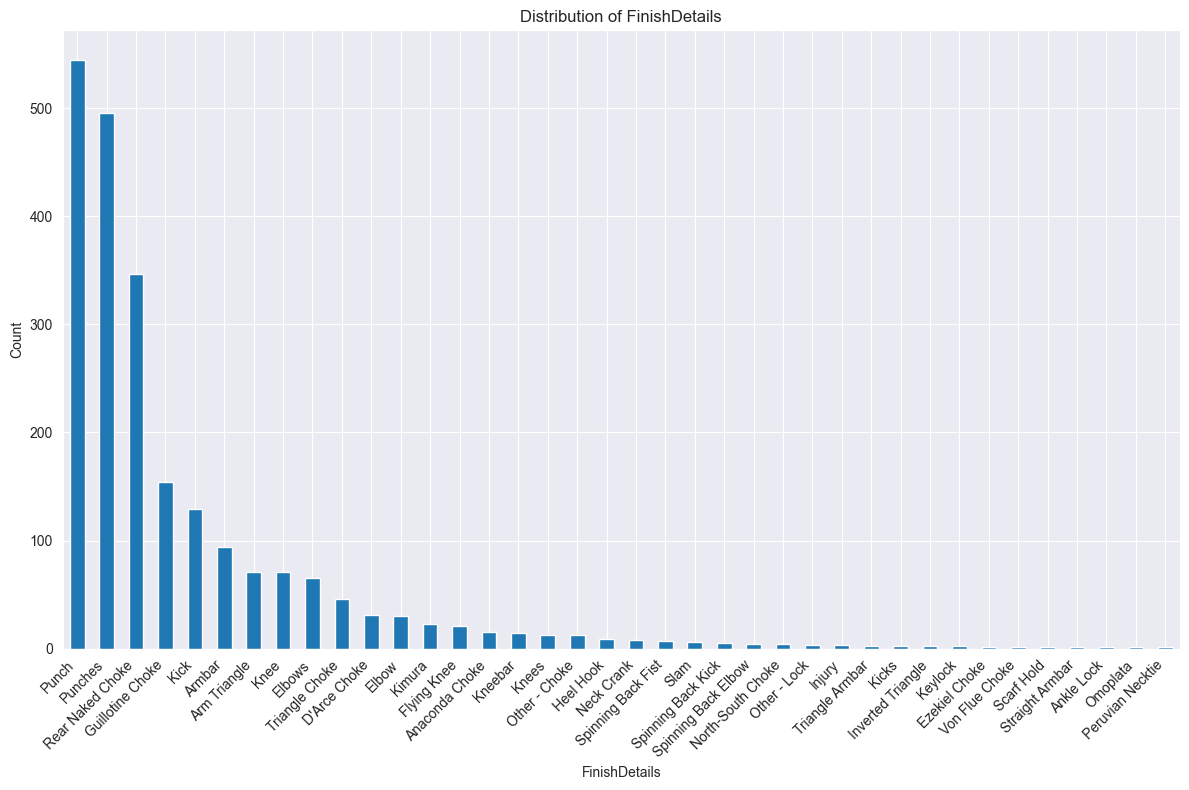

In [38]:
finish_details_counts = ufc_data_master['FinishDetails'].value_counts()

plt.figure(figsize=(12, 8))
finish_details_counts.plot(kind='bar')
plt.title('Distribution of FinishDetails')
plt.xlabel('FinishDetails')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Most common submission

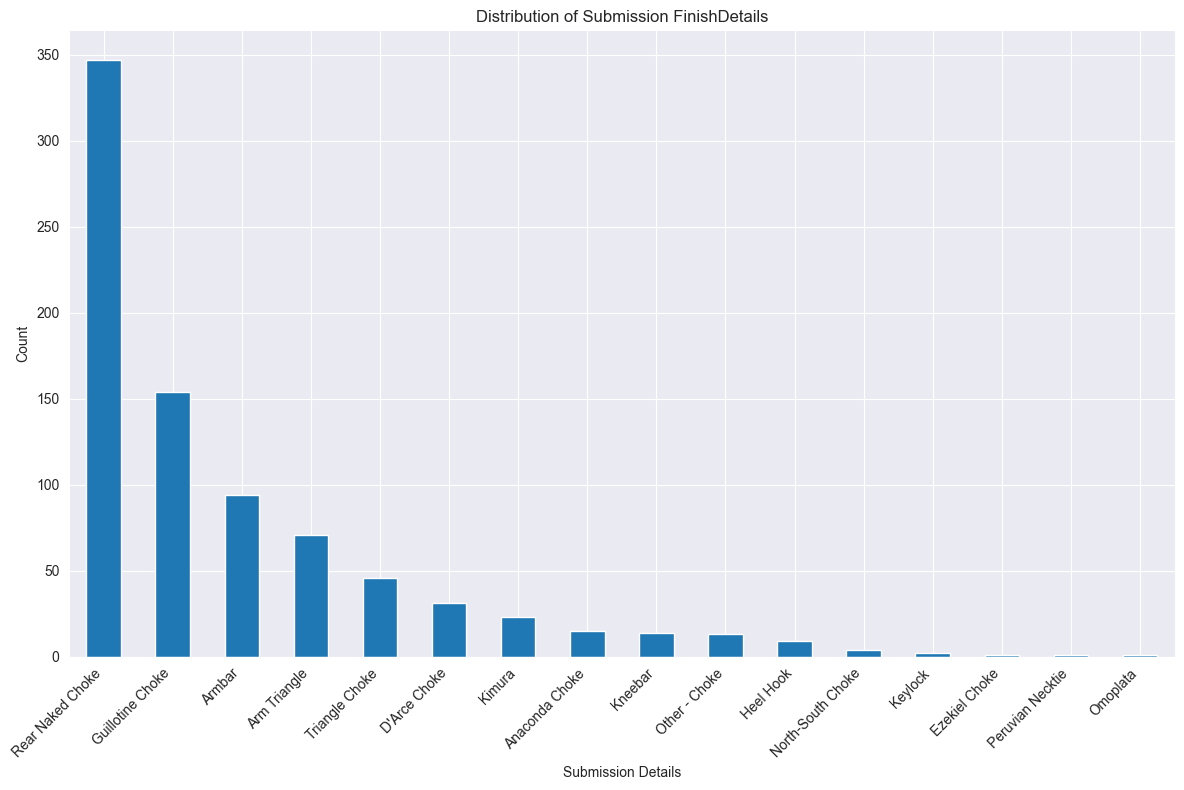

In [39]:
submission_keywords = [
    'Rear Naked Choke', 'Armbar', 'Guillotine Choke', 'Arm Triangle',
    "D'Arce Choke", 'Triangle Choke', 'Kimura', 'Ezekiel Choke',
    'Kneebar', 'Anaconda Choke', 'Heel Hook', 'Keylock',
    'Other - Choke', 'Peruvian Necktie', 'Omoplata', 'North-South Choke'
]

submission_details = ufc_data_master[ufc_data_master['FinishDetails'].isin(submission_keywords)]

submission_counts = submission_details['FinishDetails'].value_counts()

plt.figure(figsize=(12, 8))
submission_counts.plot(kind='bar')
plt.title('Distribution of Submission FinishDetails')
plt.xlabel('Submission Details')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

ufc_data_master.drop(['FinishDetails'], axis=1, inplace=True)

## Submission statistics matrix
Correlation matrix to display how strong of a correlation the features have to predict the 'Finish_SUB' fight outcome.

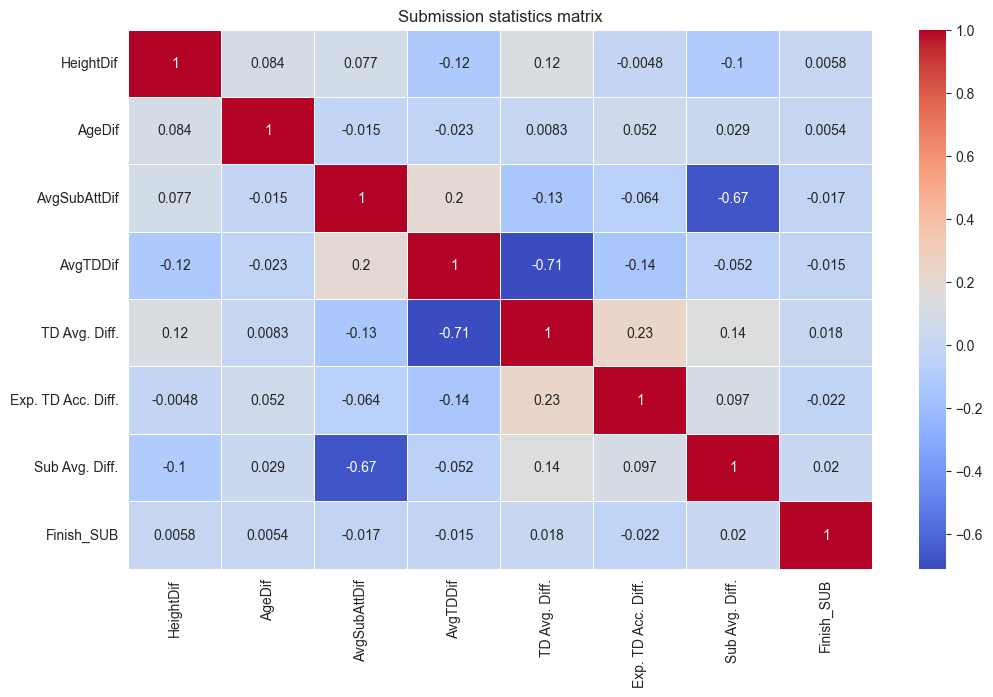

In [40]:
submission_features = ["HeightDif","AgeDif","AvgSubAttDif","AvgTDDif","TD Avg. Diff.","Exp. TD Acc. Diff.", "Sub Avg. Diff.", "Finish_SUB"]

correlation_submission = ufc_data_master[submission_features]

correlation_matrix_submission = correlation_submission.corr()

plt.figure(figsize=(12,7))
sns.heatmap(correlation_matrix_submission, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Submission statistics matrix')
plt.show()

## Decision statistics matrix

Correlation matrix to display how strong of a correlation the features have to predict the 'Finish_U-DEC' fight outcome.

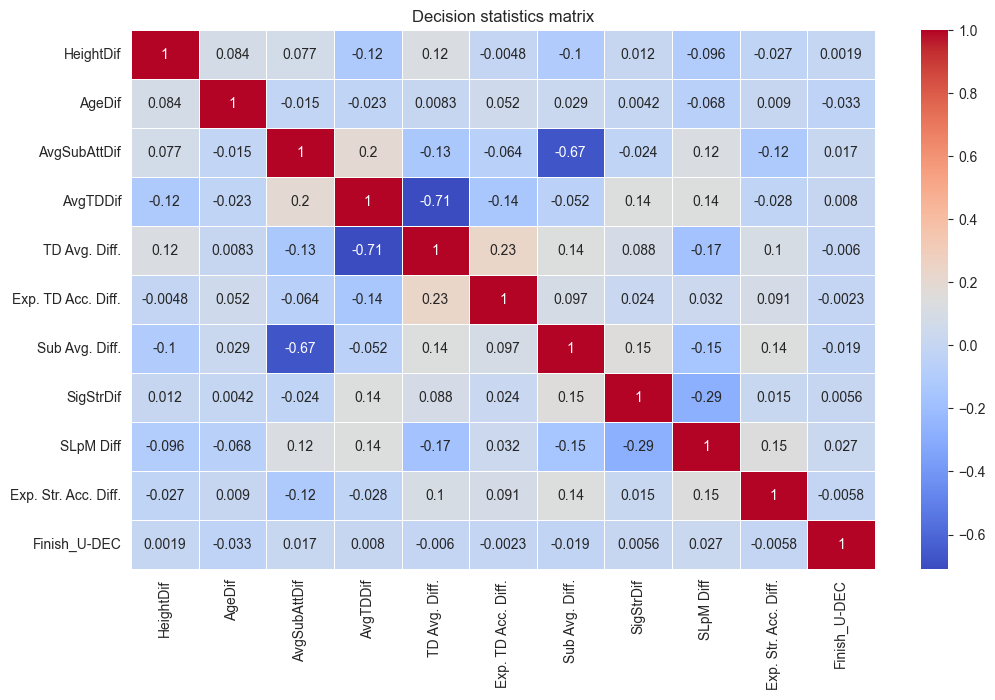

In [41]:
decision_features = ["HeightDif","AgeDif","AvgSubAttDif","AvgTDDif","TD Avg. Diff.","Exp. TD Acc. Diff.", "Sub Avg. Diff.","SigStrDif","SLpM Diff","Exp. Str. Acc. Diff.", "Finish_U-DEC"]

correlation_decision = ufc_data_master[decision_features]

correlation_matrix_decision = correlation_decision.corr()

plt.figure(figsize=(12,7))
sns.heatmap(correlation_matrix_decision, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Decision statistics matrix')
plt.show()

## Scatter plot for Finish_KO/TKO

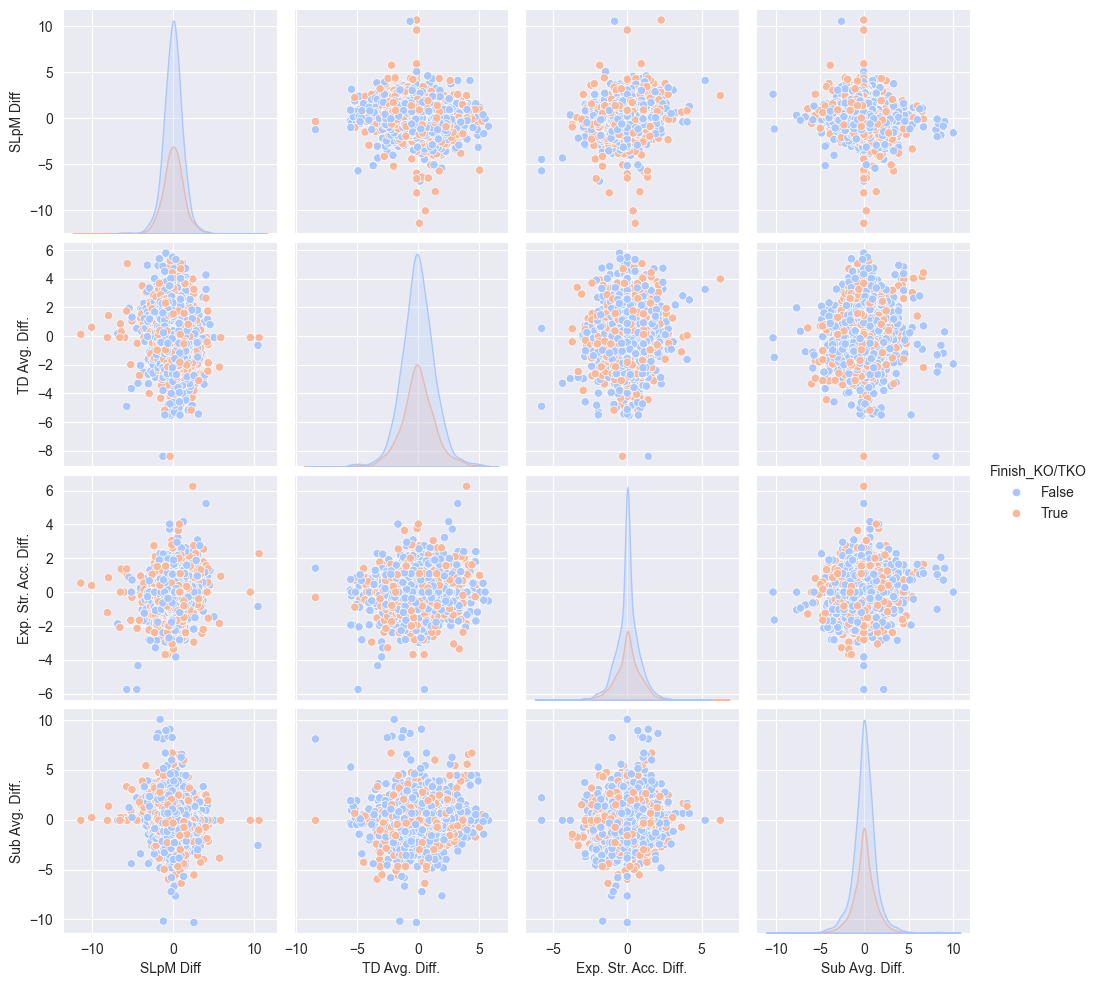

In [42]:
sns.pairplot(data=ufc_data_master, vars=["SLpM Diff",
       "TD Avg. Diff.", "Exp. Str. Acc. Diff.", "Sub Avg. Diff."],
             hue="Finish_KO/TKO", palette="coolwarm", diag_kind="kde")
plt.show()

# Modelling
For the project I will train the dataset with four different models, each representing a different target variable corresponding to the different finish I am trying to predict. Each model will have a baseline model then I use it to optimize it, using hyperparameter tuning, oversampling and undersampling.

Undersampling
- Ensures the model doesn't "overlearn" patterns from the majority class (e.g., always predicting `Blue`).
- Forces the model to treat the minority class (`Red`) equally during training, improving its ability to predict `Red` wins.

Oversampling
- Helps create synthetic samples for Red wins to balance the dataset. There is also a risk involved: duplicated samples or synthetic samples may cause the model to memorize patterns instead of learning generalizable features.

## Data prepare
Reusable methods for all the models below

In [43]:
common_features = [
    'RedOdds', 'RedDecOdds', 'BlueOdds', 'RSubOdds', 'BSubOdds',
    'RKOOdds', 'BKOOdds', 'BlueOdds', 'Finish_KO/TKO', 'Finish_SUB',
    'Finish_U-DEC', 'Finish_Overturned', 'BlueDecOdds', 'Finish_M-DEC',
    'Finish_DQ', 'Finish_S-DEC', 'Winner'
]

def prepare_data(target):
    X = ufc_data_master.drop(columns=common_features + [target])
    y = ufc_data_master[target]

    # Select numerical features and fill missing values
    X = X.select_dtypes(include=['number']).fillna(0)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split data into training and testing sets
    return train_test_split(X_scaled, y, test_size=0.2, random_state=42)

def plot_confusion_matrix(y_test, y_pred, title):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Blue', 'Red'])
    disp.plot(cmap='Blues')
    disp.ax_.set_title(title)
    plt.show()

## Model for winner prediction

Baseline Model Accuracy (Winner): 0.6275100401606426
Classification Report (Winner):
              precision    recall  f1-score   support

           0       0.64      0.77      0.70       562
           1       0.60      0.44      0.51       434

    accuracy                           0.63       996
   macro avg       0.62      0.61      0.60       996
weighted avg       0.62      0.63      0.62       996



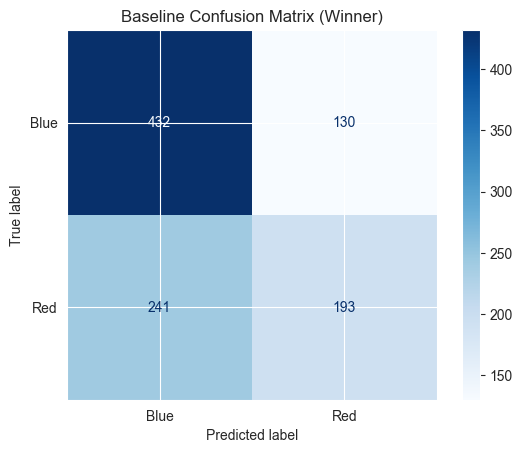

Tuned Model Accuracy (Winner): 0.6275100401606426


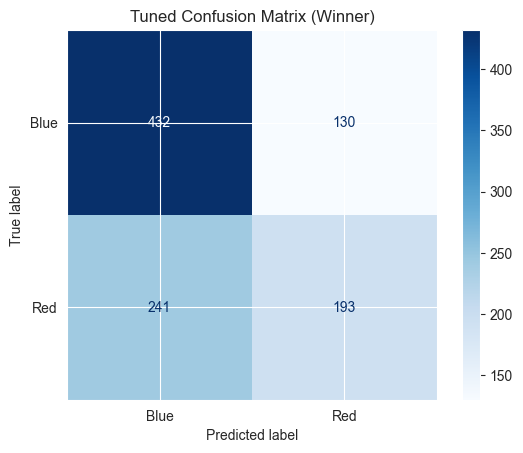

Oversampled Model Accuracy (Winner): 0.641566265060241


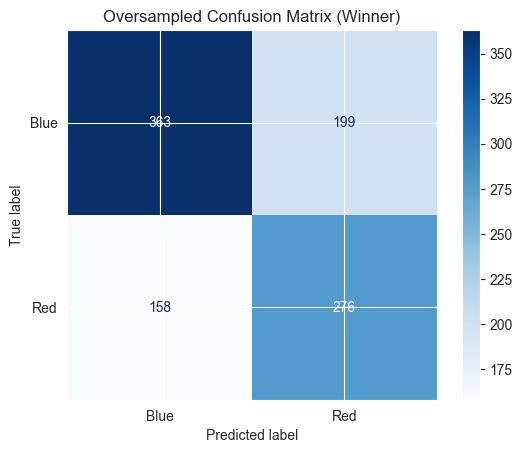

Undersampled Model Accuracy (Winner): 0.6375502008032129


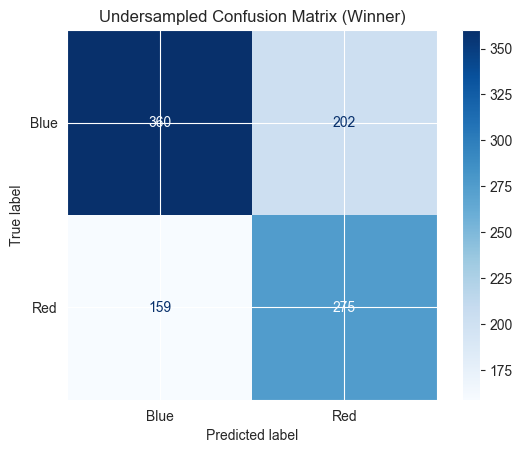

In [44]:
x_train, x_test, y_train, y_test = prepare_data('Winner')

model = LogisticRegression(random_state=42)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print("Baseline Model Accuracy (Winner):", accuracy_score(y_test, y_pred))
print("Classification Report (Winner):")
print(classification_report(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred, "Baseline Confusion Matrix (Winner)")

# Hyperparameter tuning the baseline
param_grid = {'C': [0.01, 0.1, 1, 10], 'solver': ['liblinear', 'lbfgs']}
grid_search = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)
best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(x_test)
print("Tuned Model Accuracy (Winner):", accuracy_score(y_test, y_pred_tuned))
plot_confusion_matrix(y_test, y_pred_tuned, "Tuned Confusion Matrix (Winner)")

# Oversampling the baseline
smote = SMOTE(random_state=42)
x_train_oversampled, y_train_oversampled = smote.fit_resample(x_train, y_train)
oversampled_model = LogisticRegression(random_state=42)
oversampled_model.fit(x_train_oversampled, y_train_oversampled)
y_pred_oversampled = oversampled_model.predict(x_test)
print("Oversampled Model Accuracy (Winner):", accuracy_score(y_test, y_pred_oversampled))
plot_confusion_matrix(y_test, y_pred_oversampled, "Oversampled Confusion Matrix (Winner)")
#Saving the oversampled model
joblib.dump(oversampled_model, 'model_winner.pkl')

# Undersampling the baseline
undersampler = RandomUnderSampler(random_state=42)
x_train_undersampled, y_train_undersampled = undersampler.fit_resample(x_train, y_train)
undersampled_model = LogisticRegression(random_state=42)
undersampled_model.fit(x_train_undersampled, y_train_undersampled)
y_pred_undersampled = undersampled_model.predict(x_test)
print("Undersampled Model Accuracy (Winner):", accuracy_score(y_test, y_pred_undersampled))
plot_confusion_matrix(y_test, y_pred_undersampled, "Undersampled Confusion Matrix (Winner)")


### Difference of wins in the red and blue corner

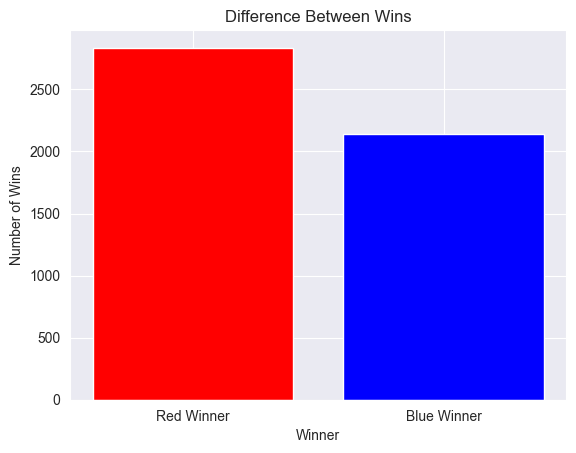

In [45]:
red_winner = ufc_data_master[ufc_data_master['Winner'] == 0].shape[0]
blue_winner = ufc_data_master[ufc_data_master['Winner'] == 1].shape[0]

categories = ['Red Winner', 'Blue Winner']
values = [red_winner, blue_winner]

plt.bar(categories, values, color=['red', 'blue'])
plt.title('Difference Between Wins')
plt.xlabel('Winner')
plt.ylabel('Number of Wins')
plt.show()

## Model for KO/TKO prediction

Baseline Model Accuracy (Finish_KO/TKO): 0.6716867469879518
Classification Report (Finish_KO/TKO):
              precision    recall  f1-score   support

       False       0.68      0.94      0.79       657
        True       0.57      0.15      0.24       339

    accuracy                           0.67       996
   macro avg       0.62      0.55      0.51       996
weighted avg       0.64      0.67      0.60       996



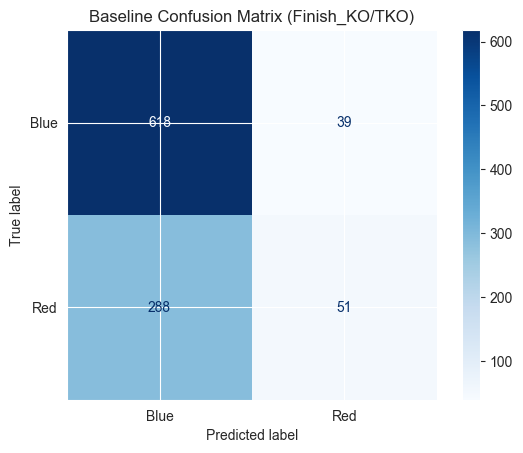

Tuned Model Accuracy (Finish_KO/TKO): 0.6716867469879518


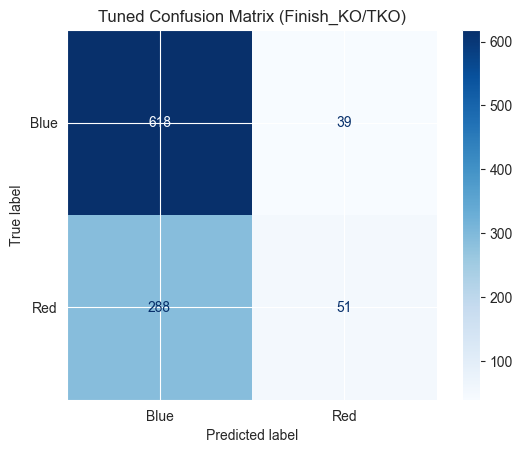

Oversampled Model Accuracy (Finish_KO/TKO): 0.607429718875502


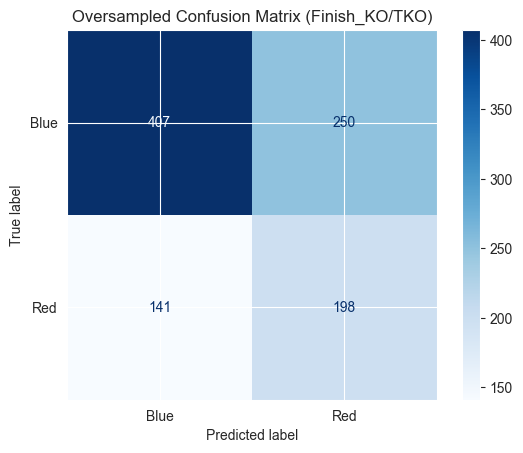

Undersampled Model Accuracy (Finish_KO/TKO): 0.6255020080321285


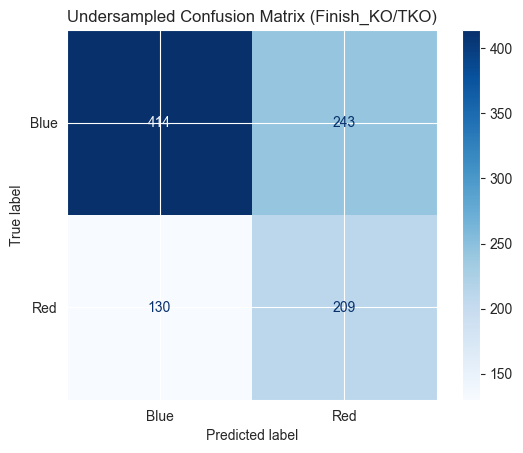

In [46]:
x_train, x_test, y_train, y_test = prepare_data('Finish_KO/TKO')

#Baseline model
model = LogisticRegression(random_state=42)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print("Baseline Model Accuracy (Finish_KO/TKO):", accuracy_score(y_test, y_pred))
print("Classification Report (Finish_KO/TKO):")
print(classification_report(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred, "Baseline Confusion Matrix (Finish_KO/TKO)")

#Hyperparameter tuning
param_grid = {'C': [0.01, 0.1, 1, 10], 'solver': ['liblinear', 'lbfgs']}
grid_search = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)
best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(x_test)
print("Tuned Model Accuracy (Finish_KO/TKO):", accuracy_score(y_test, y_pred_tuned))
plot_confusion_matrix(y_test, y_pred_tuned, "Tuned Confusion Matrix (Finish_KO/TKO)")
#Saving the hyperparameter model
joblib.dump(grid_search.best_estimator_, 'model_ko_tko.pkl')

#Oversampling
smote = SMOTE(random_state=42)
x_train_oversampled, y_train_oversampled = smote.fit_resample(x_train, y_train)
oversampled_model = LogisticRegression(random_state=42)
oversampled_model.fit(x_train_oversampled, y_train_oversampled)
y_pred_oversampled = oversampled_model.predict(x_test)
print("Oversampled Model Accuracy (Finish_KO/TKO):", accuracy_score(y_test, y_pred_oversampled))
plot_confusion_matrix(y_test, y_pred_oversampled, "Oversampled Confusion Matrix (Finish_KO/TKO)")

#Undersampling
undersampler = RandomUnderSampler(random_state=42)
x_train_undersampled, y_train_undersampled = undersampler.fit_resample(x_train, y_train)
undersampled_model = LogisticRegression(random_state=42)
undersampled_model.fit(x_train_undersampled, y_train_undersampled)
y_pred_undersampled = undersampled_model.predict(x_test)
print("Undersampled Model Accuracy (Finish_KO/TKO):", accuracy_score(y_test, y_pred_undersampled))
plot_confusion_matrix(y_test, y_pred_undersampled, "Undersampled Confusion Matrix (Finish_KO/TKO)")


## Model for submission prediction

Baseline Model Accuracy (Finish_SUB): 0.8022088353413654
Classification Report (Finish_SUB):
              precision    recall  f1-score   support

       False       0.81      0.98      0.89       804
        True       0.40      0.05      0.09       192

    accuracy                           0.80       996
   macro avg       0.61      0.52      0.49       996
weighted avg       0.73      0.80      0.74       996



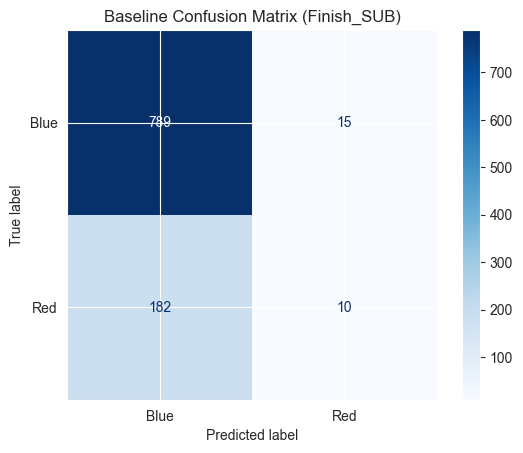

Tuned Model Accuracy (Finish_SUB): 0.8032128514056225


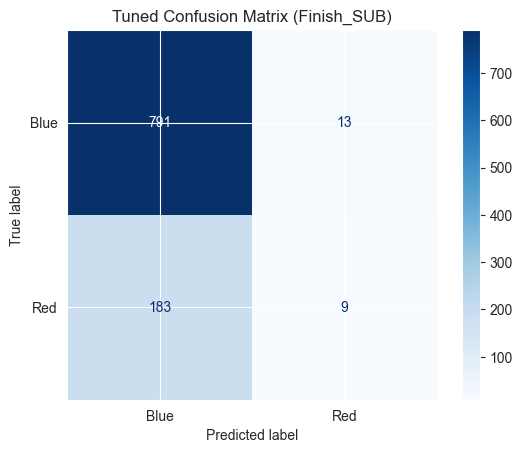

Oversampled Model Accuracy (Finish_SUB): 0.6375502008032129


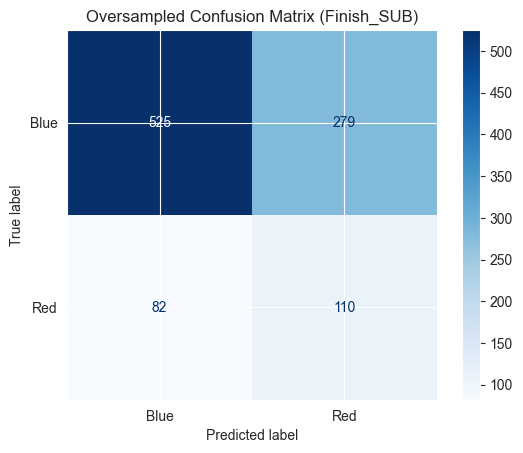

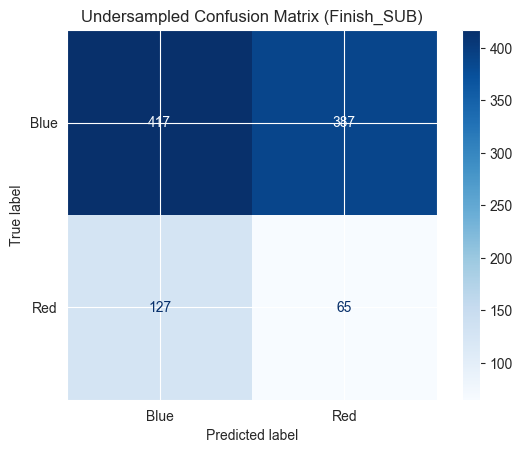

Oversampled Model Accuracy (Finish_SUB): 0.4839357429718876


['model_submission.pkl']

In [52]:
x_train, x_test, y_train, y_test = prepare_data('Finish_SUB')

#baseline model
model = LogisticRegression(random_state=42)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print("Baseline Model Accuracy (Finish_SUB):", accuracy_score(y_test, y_pred))
print("Classification Report (Finish_SUB):")
print(classification_report(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred, "Baseline Confusion Matrix (Finish_SUB)")

#hyperparameter tuning
param_grid = {'C': [0.01, 0.1, 1, 10], 'solver': ['liblinear', 'lbfgs']}
grid_search = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)
best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(x_test)
print("Tuned Model Accuracy (Finish_SUB):", accuracy_score(y_test, y_pred_tuned))
plot_confusion_matrix(y_test, y_pred_tuned, "Tuned Confusion Matrix (Finish_SUB)")

#oversampling
smote = SMOTE(random_state=42)
x_train_oversampled, y_train_oversampled = smote.fit_resample(x_train, y_train)
oversampled_model = LogisticRegression(random_state=42)
oversampled_model.fit(x_train_oversampled, y_train_oversampled)
y_pred_oversampled = oversampled_model.predict(x_test)
print("Oversampled Model Accuracy (Finish_SUB):", accuracy_score(y_test, y_pred_oversampled))
plot_confusion_matrix(y_test, y_pred_oversampled, "Oversampled Confusion Matrix (Finish_SUB)")

#undersampling
undersampler = RandomUnderSampler(random_state=42)
x_train_undersampled, y_train_undersampled = undersampler.fit_resample(x_train, y_train)
undersampled_model_sub = LogisticRegression(random_state=42)
undersampled_model_sub.fit(x_train_undersampled, y_train_undersampled)
plot_confusion_matrix(y_test, y_pred_undersampled, "Oversampled Confusion Matrix (Finish_SUB)")
print("Oversampled Model Accuracy (Finish_SUB):", accuracy_score(y_test, y_pred_undersampled))
#saving the undersampled model
joblib.dump(undersampled_model_sub, 'model_submission.pkl')


## Model for unanimous decision prediction

Baseline Model Accuracy (Finish_U-DEC): 0.6666666666666666
Classification Report (Finish_U-DEC):
              precision    recall  f1-score   support

       False       0.68      0.91      0.78       652
        True       0.55      0.20      0.29       344

    accuracy                           0.67       996
   macro avg       0.62      0.56      0.54       996
weighted avg       0.64      0.67      0.61       996



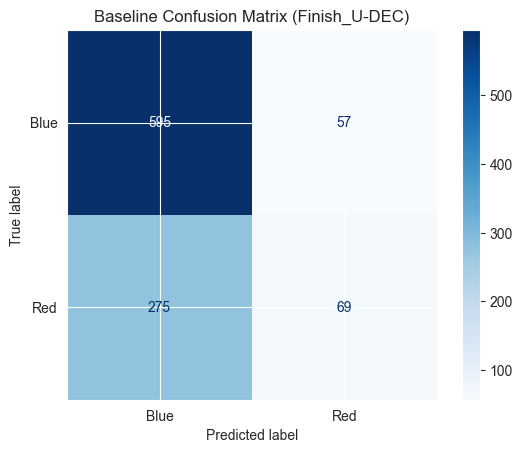

Tuned Model Accuracy (Finish_U-DEC): 0.6636546184738956


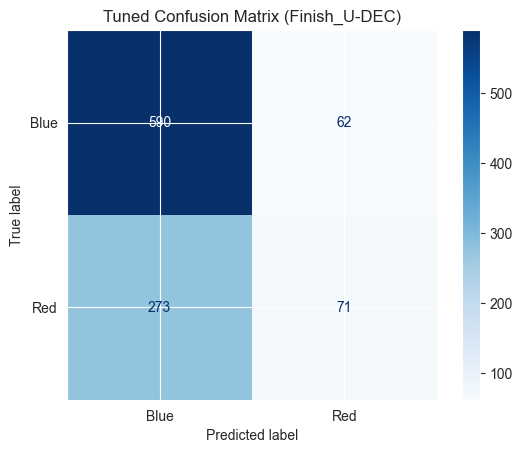

Oversampled Model Accuracy (Finish_U-DEC): 0.5732931726907631


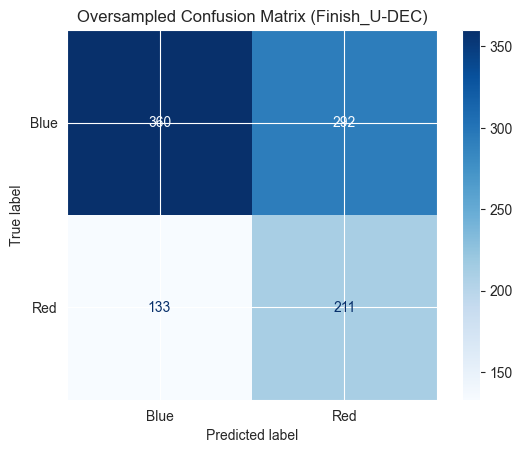

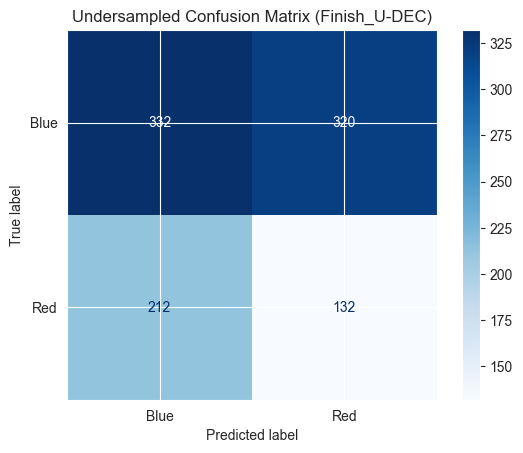

Undersampled Model Accuracy (Finish_U-DEC): 0.46586345381526106


['model_udec.pkl']

In [53]:
x_train, x_test, y_train, y_test = prepare_data('Finish_U-DEC')

#baseline
model = LogisticRegression(random_state=42)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print("Baseline Model Accuracy (Finish_U-DEC):", accuracy_score(y_test, y_pred))
print("Classification Report (Finish_U-DEC):")
print(classification_report(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred, "Baseline Confusion Matrix (Finish_U-DEC)")

#hyperparameter tuning
param_grid = {'C': [0.01, 0.1, 1, 10], 'solver': ['liblinear', 'lbfgs']}
grid_search = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)
best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(x_test)
print("Tuned Model Accuracy (Finish_U-DEC):", accuracy_score(y_test, y_pred_tuned))
plot_confusion_matrix(y_test, y_pred_tuned, "Tuned Confusion Matrix (Finish_U-DEC)")

#oversampling
smote = SMOTE(random_state=42)
x_train_oversampled, y_train_oversampled = smote.fit_resample(x_train, y_train)
oversampled_model = LogisticRegression(random_state=42)
oversampled_model.fit(x_train_oversampled, y_train_oversampled)
y_pred_oversampled = oversampled_model.predict(x_test)
print("Oversampled Model Accuracy (Finish_U-DEC):", accuracy_score(y_test, y_pred_oversampled))
plot_confusion_matrix(y_test, y_pred_oversampled, "Oversampled Confusion Matrix (Finish_U-DEC)")

#undersampling
undersampler = RandomUnderSampler(random_state=42)
x_train_undersampled, y_train_undersampled = undersampler.fit_resample(x_train, y_train)
undersampled_model_udec = LogisticRegression(random_state=42)
undersampled_model_udec.fit(x_train_undersampled, y_train_undersampled)
plot_confusion_matrix(y_test, y_pred_undersampled, "Undersampled Confusion Matrix (Finish_U-DEC)")
print("Undersampled Model Accuracy (Finish_U-DEC):", accuracy_score(y_test, y_pred_undersampled))
#saving the undersampled model
joblib.dump(undersampled_model_udec, 'model_udec.pkl')

# Usage of the models

In [50]:
models = {
    'Finish_KO/TKO': joblib.load('model_ko_tko.pkl'),
    'Winner': joblib.load('model_winner.pkl'),
    'Finish_SUB': joblib.load('model_submission.pkl'),
    'Finish_U-DEC': joblib.load('model_udec.pkl'),
}
def scrape_fighter_data(fighter_url):
    """
    Scrapes fighter statistics from a UFCStats fighter details page.

    Args:
        fighter_url: The URL of the fighter's details page on UFCStats.com.

    Returns:
        A dictionary containing the fighter's statistics, or None if an error occurs.
    """
    try:
        response = requests.get(fighter_url)
        response.raise_for_status()  # Raise an exception for bad status codes

        soup = BeautifulSoup(response.content, 'html.parser')

        # Extract fighter name
        name_element = soup.find('span', class_='b-content__title-highlight')
        name = name_element.get_text(strip=True) if name_element else None

        # Extract statistics
        stats_tables = soup.find_all('ul', class_='b-list__box-list')
        statistics = {'Name': name} if name else {}  # Initialize with name if available
        for table in stats_tables:
          for item in table.find_all('li', class_='b-list__box-list-item'):
              text = item.get_text(strip=True)
              if ':' in text:
                  key, value = [s.strip() for s in text.split(':', 1)]
                  statistics[key] = value

        return statistics

    except requests.exceptions.RequestException as e:
        print(f"Error fetching the fighter's page: {e}")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

def get_ufc_fighter_stats(fighter_url):
  fighter_statistics = scrape_fighter_data(fighter_url)

  if fighter_statistics:
    dob_str = fighter_statistics.get('DOB', 'Jan 01, 1900')
    dob = pd.to_datetime(dob_str, format='%b %d, %Y', errors='coerce')
    if pd.notnull(dob):
      age = (pd.Timestamp.now() - dob).days // 365
    else:
      age = None

    feet, inches = map(int, fighter_statistics.get('Height', '0\' 0"').replace('"', '').split('\' '))
    height_cm = (feet * 12 + inches) * 2.54

    return {
        'Name': fighter_statistics.get('Name', None),
        'Height': height_cm,
        'Weight': int(fighter_statistics.get('Weight', '0 lbs').split(' ')[0]),
        'Reach': float(fighter_statistics.get('Reach', '0').replace('"', '')) * 2.54,
        'Stance': fighter_statistics.get('STANCE', None),
        'SLpM': float(fighter_statistics.get('SLpM', 0)),
        'Str. Acc.': int(fighter_statistics.get('Str. Acc.', '0%').replace('%', '')),
        'SApM': float(fighter_statistics.get('SApM', 0)),
        'Str. Def.': int(fighter_statistics.get('Str. Def', '0%').replace('%', '')),
        'TD Avg.': float(fighter_statistics.get('TD Avg.', 0)),
        'TD Acc.': int(fighter_statistics.get('TD Acc.', '0%').replace('%', '')),
        'TD Def.': int(fighter_statistics.get('TD Def.', '0%').replace('%', '')),
        'Sub. Avg.': float(fighter_statistics.get('Sub. Avg.', 0)),
        'Age': age,
    }
  else:
    print("Could not retrieve fighter statistics.")
    return None

def predict_fight(fighter_url_1, fighter_url_2):
    """
    Predicts the outcome of a fight between two fighters based on their scraped statistics.

    Args:
        fighter_url_1: The URL of the first fighter's details page.
        fighter_url_2: The URL of the second fighter's details page.

    Returns:
        None. Prints the prediction results to the console.
    """

    # Scrape fighter statistics
    fighter1_stats = get_ufc_fighter_stats(fighter_url_1)
    fighter2_stats = get_ufc_fighter_stats(fighter_url_2)

    # Check if stats for both fighters were successfully scraped
    if not fighter1_stats or not fighter2_stats:
        print("Error: Could not scrape statistics for both fighters.")
        return

    # Calculate feature differences (Fighter 1 as Blue, Fighter 2 as Red)
    feature_differences = {
        'HeightDif': fighter1_stats['Height'] - fighter2_stats['Height'],
        'ReachDif': fighter1_stats['Reach'] - fighter2_stats['Reach'],
        'SLpM Diff': fighter1_stats['SLpM'] - fighter2_stats['SLpM'],
        'Exp. Str. Acc. Diff.': fighter1_stats['Str. Acc.'] - fighter2_stats['Str. Acc.'],
        'SApM Diff': fighter1_stats['SApM'] - fighter2_stats['SApM'],
        'Exp. Str. Def. Diff.': fighter1_stats['Str. Def.'] - fighter2_stats['Str. Def.'],
        'TD Avg. Diff.': fighter1_stats['TD Avg.'] - fighter2_stats['TD Avg.'],
        'Exp. TD Acc. Diff.': fighter1_stats['TD Acc.'] - fighter2_stats['TD Acc.'],
        'TD Def. Diff.': fighter1_stats['TD Def.'] - fighter2_stats['TD Def.'],
        'Sub Avg. Diff.': fighter1_stats['Sub. Avg.'] - fighter2_stats['Sub. Avg.'],
        'AgeDif': fighter1_stats['Age'] - fighter2_stats['Age']
    }

    # Convert feature differences to DataFrame
    fight_data = pd.DataFrame([feature_differences])

    # Ensure columns match model input (fill missing columns with 0)
    fight_data = fight_data.reindex(columns=X.columns, fill_value=0)

    # Scale the fight data
    fight_data_scaled = scaler.transform(fight_data)

    # Make Predictions
    for outcome, model in models.items():
        fight_prediction_proba = model.predict_proba(fight_data_scaled)
        fight_prediction = model.predict(fight_data_scaled)

        print(f"Prediction for {outcome}:")
        if outcome == 'Winner':
            print(f"  Probability of Red ({fighter2_stats['Name']}) Winning: {fight_prediction_proba[0][0] * 100:.2f}%")
            print(f"  Probability of Blue ({fighter1_stats['Name']}) Winning: {fight_prediction_proba[0][1] * 100:.2f}%")
            print(f"  Predicted Winner: {'Red' if fight_prediction[0] == 0 else 'Blue'}")
        else:
            print(f"  Probability of outcome being false (not a {outcome}): {fight_prediction_proba[0][0] * 100:.2f}%")
            print(f"  Probability of outcome being true ({outcome}): {fight_prediction_proba[0][1] * 100:.2f}%")
        print("-" * 50)


# Example Usage:
fighter_url_1 = "http://ufcstats.com/fighter-details/275aca31f61ba28c"  # Replace with the URL of the first fighter
fighter_url_2 = "http://ufcstats.com/fighter-details/f4c49976c75c5ab2"
# Replace with the URL of the second fighter
predict_fight(fighter_url_1, fighter_url_2)

NameError: name 'X' is not defined